# Predicting Bus Delay
## Data retreived from MTA SIRI Bus API
### Data Cleaning

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('M1-train.csv')
df.head()

,Timestamp,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,StopPointRef,StopsFromCall,VehicleRef,VisitNumber,DayOfWeek,Holiday,BusLane,VehicleDistanceAlongRoute,Segment,NewVehicleRef
0,2018-04-06 16:00:01-04:00,233.35362,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5169.49,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,23.58,...,MTA_400117,0,MTA NYCT_3891,1,5,0,True,5145.91,188189,MTA NYCT_3891_1
1,2018-04-06 16:00:32-04:00,233.91893,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5398.92,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,107.21,...,MTA_400118,0,MTA NYCT_3891,1,5,0,True,5291.71,188189,MTA NYCT_3891_1
2,2018-04-06 16:01:04-04:00,233.91893,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5398.92,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,105.06,...,MTA_400118,0,MTA NYCT_3891,1,5,0,True,5293.86,188189,MTA NYCT_3891_1
3,2018-04-06 16:01:34-04:00,234.37209,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5398.92,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,4.29,...,MTA_400118,0,MTA NYCT_3891,1,5,0,True,5394.63,188189,MTA NYCT_3891_1
4,2018-04-06 16:02:06-04:00,233.95068,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5621.35,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,203.00,...,MTA_400119,0,MTA NYCT_3891,1,5,0,True,5418.35,188189,MTA NYCT_3891_1


In [5]:
seg = pd.read_csv('data/traffic-features-mim.csv')
seg

,segment_id,ID,from,to,segment,meter,feet,intersections,blocks,busstops
0,1,188189,188,189,5th Avenue - Southbound - 96th St to 86th St,811.76,2663.22,11,10,4
1,2,18922,189,22,5th Avenue - Southbound - 86th St to 72nd St,1153.06,3782.96,15,14,5
2,3,2216,22,16,5th Avenue - Southbound - 72nd St to 57th St,1207.64,3962.03,16,15,6
3,4,1615,16,15,5th Avenue - Southbound - 57th St to 49th St,642.36,2107.45,9,8,1
4,5,1514,15,14,5th Avenue - Southbound - 49th St to 42nd St,564.20,1851.03,8,7,3
5,6,14118,14,118,5th Avenue - Southbound - 42nd St to 34th St,642.87,2109.13,9,8,3


In [6]:
#merge segment characteristics from MiM data with bus travel data
df = df.merge(seg, left_on='Segment', right_on='ID', how='inner')

In [7]:
#select only relevant features
df = df[['Timestamp','NewVehicleRef', 'VehicleDistanceAlongRoute', 'segment_id', 'DayOfWeek', 'Holiday', 'BusLane', 'intersections', 'busstops']]

In [8]:
df.head()

,Timestamp,NewVehicleRef,VehicleDistanceAlongRoute,segment_id,DayOfWeek,Holiday,BusLane,intersections,busstops
0,2018-04-06 16:00:01-04:00,MTA NYCT_3891_1,5145.91,1,5,0,True,11,4
1,2018-04-06 16:00:32-04:00,MTA NYCT_3891_1,5291.71,1,5,0,True,11,4
2,2018-04-06 16:01:04-04:00,MTA NYCT_3891_1,5293.86,1,5,0,True,11,4
3,2018-04-06 16:01:34-04:00,MTA NYCT_3891_1,5394.63,1,5,0,True,11,4
4,2018-04-06 16:02:06-04:00,MTA NYCT_3891_1,5418.35,1,5,0,True,11,4


In [9]:
#check number of buses in service on route
df.NewVehicleRef.nunique()

84

In [10]:
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.tz_localize('UTC').dt.tz_convert('America/New_York')

In [11]:
df['Time'] = df['Timestamp'].dt.strftime("%H:%M:%S")

In [12]:
df['Date'] = df['Timestamp'].dt.date

### Find Link Travel Time between segments

In [13]:
#records of buses from point closest/furthest to start of segment
dfo = df.loc[df.groupby(['NewVehicleRef', 'segment_id', 'Date'])['VehicleDistanceAlongRoute'].idxmin()]
dfd = df.loc[df.groupby(['NewVehicleRef', 'segment_id', 'Date'])['VehicleDistanceAlongRoute'].idxmax()]

In [14]:
#get difference between DistanceFromCall (y-x)
df_avg = dfo.merge(dfd, on=['NewVehicleRef', 'segment_id', 'Date'])

In [15]:
df_avg = df_avg[['Timestamp_x', 'NewVehicleRef', 'VehicleDistanceAlongRoute_x', 'VehicleDistanceAlongRoute_y', 'Timestamp_y', 'segment_id', 'DayOfWeek_y', 'Holiday_y', 'BusLane_y', 'intersections_y', 'busstops_y']]

In [16]:
#calculate distance and time between records for each segment to derive average speed
df_avg['DistanceDelta'] = df_avg['VehicleDistanceAlongRoute_y'] - df_avg['VehicleDistanceAlongRoute_x']
df_avg['TimeDelta'] = df_avg['Timestamp_y'] - df_avg['Timestamp_x']
df_avg['TimeDelta'] = df_avg['TimeDelta'].astype('timedelta64[s]').astype(int)
df_avg['AvgSpeed'] = df_avg['DistanceDelta'] / df_avg['TimeDelta']

### Categorise data into half hourly time interval bins

In [17]:
df_avg['timeinseconds'] = (df_avg['Timestamp_x'].dt.hour * 3600) + (df_avg['Timestamp_x'].dt.minute * 60) + (df_avg['Timestamp_x'].dt.second)

In [18]:
labels = [ "{}".format(i) for i in range(8) ]
df_avg['HalfHourly'] = pd.cut(df_avg.timeinseconds, range(57600, 73800, 1800), right=False, labels=labels)

In [19]:
df_avg.tail()

,Timestamp_x,NewVehicleRef,VehicleDistanceAlongRoute_x,VehicleDistanceAlongRoute_y,Timestamp_y,segment_id,DayOfWeek_y,Holiday_y,BusLane_y,intersections_y,busstops_y,DistanceDelta,TimeDelta,AvgSpeed,timeinseconds,HalfHourly
1098,2018-04-09 16:17:26-04:00,MTA NYCT_6789_1,6665.28,7662.46,2018-04-09 16:26:30-04:00,3,1,0,True,16,6,997.18,544,1.833051,58646,0
1099,2018-04-09 16:27:03-04:00,MTA NYCT_6789_1,7892.57,8457.46,2018-04-09 16:31:14-04:00,4,1,0,True,9,1,564.89,251,2.250558,59223,0
1100,2018-04-09 16:31:45-04:00,MTA NYCT_6789_1,8507.55,8953.69,2018-04-09 16:35:25-04:00,5,1,0,True,8,3,446.14,220,2.027909,59505,1
1101,2018-04-07 18:28:08-04:00,MTA NYCT_6789_1,9451.38,9451.38,2018-04-07 18:28:08-04:00,6,6,1,False,9,3,0.00,0,NaN,66488,4
1102,2018-04-09 16:35:56-04:00,MTA NYCT_6789_1,9096.18,9350.96,2018-04-09 16:38:32-04:00,6,1,0,True,9,3,254.78,156,1.633205,59756,1


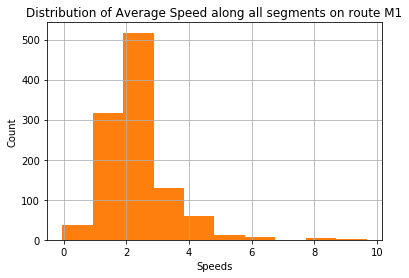

In [21]:
import matplotlib.pyplot as plt
df_avg['AvgSpeed'].hist()
plt.title('Distribution of Average Speed along all segments on route M1')
plt.xlabel('Speeds')
plt.ylabel('Count')
plt.show()


In [22]:
df_avg = df_avg[['NewVehicleRef', 'Timestamp_x', 'segment_id', 'HalfHourly', 'intersections_y', 'busstops_y',  'DayOfWeek_y', 'Holiday_y', 'BusLane_y', 'AvgSpeed']]

In [23]:
df_avg.head()

,NewVehicleRef,Timestamp_x,segment_id,HalfHourly,intersections_y,busstops_y,DayOfWeek_y,Holiday_y,BusLane_y,AvgSpeed
0,MTA NYCT_3829_1,2018-04-08 16:00:17.604000-04:00,2,0,15,5,7,1,False,2.445659
1,MTA NYCT_3829_1,2018-04-08 16:07:40.959000-04:00,3,0,16,6,7,1,False,1.806298
2,MTA NYCT_3829_1,2018-04-08 16:16:56.783000-04:00,4,0,9,1,7,1,False,1.597098
3,MTA NYCT_3829_1,2018-04-08 16:21:42.724000-04:00,5,0,8,3,7,1,False,2.701809
4,MTA NYCT_3829_1,2018-04-08 16:23:49.024000-04:00,6,0,9,3,7,1,False,3.600640


In [24]:
df_avg.to_csv('bus_train.csv', index=False)

In [25]:
df_avg.shape

(1103, 10)